In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import asdict
from datetime import datetime
import cartopy.crs as ccrs
import easygems.healpix as egh
import intake
import matplotlib.pyplot as plt
import numpy as np
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal, mindelo, find_ec_lon, vertical_preview, to_kml

In [3]:
# Domain definition
lon_min, lon_max, lat_min, lat_max = -65, -5, -10, 25

# Define dates for forecast initialization and flight

issued_time = datetime(2024, 8, 22, 0, 0, 0)

flight_time = datetime(2024, 8, 27, 12, 0, 0)
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"

print(
    f"Initalization date of IFS forecast: {issued_time}\n"
    f"Flight date: {flight_time:%Y-%m-%d}\n"
    f"Flight index: {flight_index}"
)

crew = {'Mission PI': 'Bjorn Stevens',
        'DropSondes': 'Helene Glöckner',
        'HAMP': 'Clara Bayley',
        'SMART/VELOX': 'Kevin Wolf',
        'SpecMACS': 'Zekican Demiralay',
        'WALES' : 'Georgios Dekoutsidis',
        'Flight Documentation': 'Nicola Rochetin',
        'Ground Support': 'Marius Rixen',
        }


Initalization date of IFS forecast: 2024-08-22 00:00:00
Flight date: 2024-08-27
Flight index: HALO-20240827a


In [4]:
# Load forecast data
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
ds = cat.HIFS(datetime = issued_time).to_dask().pipe(egh.attach_coords)

# Load ec satellite track for 
ec_track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-21", kind="PRE").get_track_for_day(f"{flight_time:%Y-%m-%d}")
ec_track = ec_track.sel(time=slice(f"{flight_time:%Y-%m-%d} 06:00", None))
ec_lons, ec_lats = ec_track.lon.values, ec_track.lat.values

In [5]:
def ec_time_at_lat(ec_track, lat):
    e = np.datetime64("2024-08-01")
    s = np.timedelta64(1, "ns")
    return (((ec_track.swap_dims({"time":"lat"}).time - e) / s).interp(lat=lat) * s + e)

**Waypoint definitions**

In [6]:
# Mass flux circle radius (m)
radius = 130e3
atr_radius = 70e3
ec_offset = 0.0

# Setting region (Cabo Verde vs. Barbados)
band = "east"
airport = sal if band == "east" else bco
natal = LatLon(-5 - 47/60. - 42.00/3600.,-35 - 12/60. - 33.98/3600., label = "natal")

In [7]:
# Latitudes where we enter and leave the ec track (visually estimated)
lat_ec_north = 14.5
lat_ec_south = 5.75

# ITCZ edges visually estimated from iwv contours
lat_c_south = 4.0
lat_c_north = 11.5
lat_c_extra = 13.75

c_atr_nw = LatLon(17.433,-23.500, label = "c_atr")
c_atr_se = LatLon(16.080,-21.715, label = "c_atr")

In [8]:
# Setting lat/lon coordinates

# Points where we get on ec track
north_ec = LatLon(lat_ec_north, find_ec_lon(lat_ec_north, ec_lons, ec_lats), label = "north_ec")
south_ec = LatLon(lat_ec_south, find_ec_lon(lat_ec_south, ec_lons, ec_lats), label = "south_ec")

# Circles along ec track
c_north = LatLon(lat_c_north, find_ec_lon(lat_c_north, ec_lons, ec_lats), label = "c_north")
c_south = LatLon(lat_c_south, find_ec_lon(lat_c_south, ec_lons, ec_lats), label = "c_south")
c_mid = c_south.towards(c_north).assign(label = "c_mid")

x_wp1  = c_mid.towards(c_north,fraction=2/5.).assign(label = "x_wp1")
c_extra = LatLon(lat_c_extra, find_ec_lon(lat_c_extra, ec_lons, ec_lats), label = "c_extra")

# EarthCARE underpass (the time assignment sometimes led to errors)
ec_under = c_north.towards(north_ec,fraction=1./2.).assign(label = "ec_under")
ec_under.assign(time=str(ec_time_at_lat(ec_track, ec_under.lat).values)+"Z")

# Define flight track
outbound_legs = [
     airport, 
     north_ec.assign(fl=410),
     ]

ec_legs = [
     south_ec.assign(fl=410),
     IntoCircle(c_south.assign(fl=430), radius, -330,enter=220),   
     south_ec.assign(fl=430),
     IntoCircle(c_mid.assign(fl=430), radius, 360), 
     x_wp1.assign(fl=450),
     IntoCircle(c_north.assign(fl=450), radius, 360),   
     ec_under.assign(fl=450),
     ]

inbound_legs = [
     north_ec.assign(fl=450),
     IntoCircle(c_atr_se.assign(fl=350), atr_radius, 330),
     airport,
     ]

waypoints = outbound_legs + ec_legs + inbound_legs 

waypoint_centers = []
for point in waypoints:
    if isinstance(point, IntoCircle):
        point = point.center
    waypoint_centers.append(point)

path = fp.expand_path(waypoints, dx=10e3)

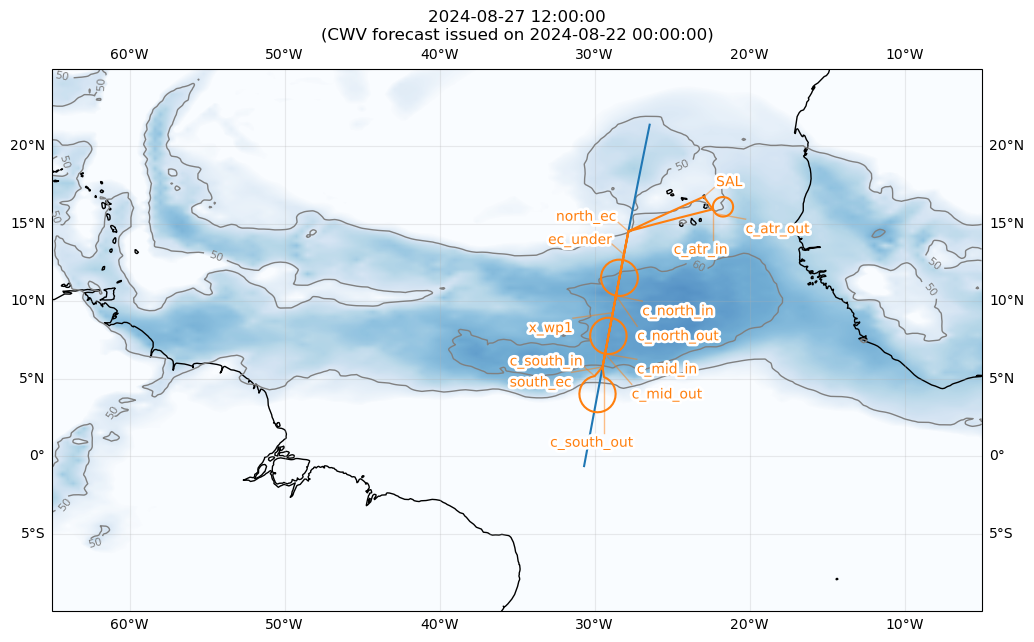

In [9]:
plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [50.0, 60.0])
plt.title(f"{flight_time}\n(CWV forecast issued on {issued_time})")

plt.plot(ec_lons, ec_lats)
fp.plot_path(path, ax, color="C1")
#fp.plot_path([natal,sal], ax, color="red")
plt.savefig(f'{flight_index}_track.png')

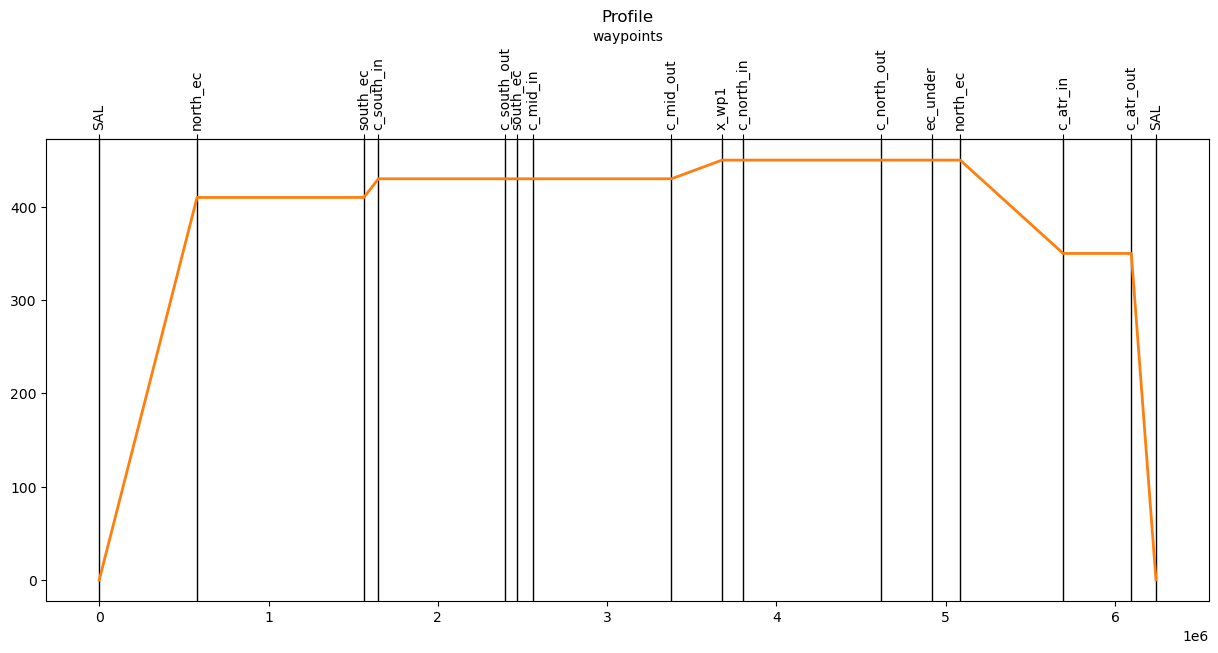

In [10]:
vertical_preview(waypoints)
plt.title("Profile")
plt.savefig(f'{flight_index}_profile.png')

In [11]:
plan = path.isel(distance = path.waypoint_indices).to_dataframe().set_index("waypoint_labels")
takeoff = np.datetime64("2025-08-27T10:11:21.4285")

xwp_2 = LatLon(lat_c_south-1, find_ec_lon(lat_c_south-1, ec_lons, ec_lats), label = "xwp2")
xwp_3 = LatLon(c_atr_nw.lat,c_atr_nw.lon, label = "xwp3")
extra_waypoints = [xwp_2,xwp_3]

notes = {'c_south_in':f' {radius/1852:2.0f} nm circle centered at {c_south.format_pilot()}, enter from north, CCW',
        'c_mid_in':f' {radius/1852:2.0f} nm circle centered at {c_mid.format_pilot()}, enter from south, CCW',
        'c_north_in':f' {radius/1852:2.0f} nm circle centered at {c_north.format_pilot()}, enter from south, CCW',
        'c_atr_in':f' {atr_radius/1852:2.0f} nm circle centered at {c_atr_se.format_pilot()}, enter from west, CW',
        'xwp2':'Alternative center for c_south',
        'xwp3':'Alternative center for c_atr',
         }


### Export kml and text file for FX and pilots

In [12]:
with open(f"{flight_index}.kml", "w") as f:
    f.write(to_kml(path))

In [13]:
with open( f"{flight_index}_waypoints.txt", "w") as file:
    file.write(f"Flight {flight_index}\n\n")
    #
    # DM Format
    file.write("DM Format:\n")
    file.write(" ".join(wp.format_1min() for wp in waypoint_centers) + "\n")
    for point in extra_waypoints:
        file.write(f"Extra waypoint: {point.format_1min()}\n")
    #
    # DM.mm format
    file.write("\nDMmm Format:\n")
    file.write(" ".join(wp.format_pilot() for wp in waypoint_centers) + "\n")
    for point in extra_waypoints:
        file.write(f"Extra waypoint: {point.format_pilot()}\n")
    #
    # Detailed overview with notes
    file.write(f"\n\nDetailed Overview:\n")
    for index, row in plan.iterrows():
        if (index[0]+index[-4:]!='c_out'):
            file.write(f"{index:12s} {LatLon(row['lat'],row['lon']).format_pilot():20s}, FL{int(row['fl']):03d}, {takeoff+row['duration']:%H:%M:%S}, {notes.get(index,'')}\n" )
    file.write ('\n -- circle centers:')
    for point in waypoints:
        if isinstance(point, IntoCircle):
            point = point.center
            file.write (f'\n{point.label:12s} {point.format_pilot()}')
    file.write ('\n\n -- extra waypoints:')
    for point in extra_waypoints:
        file.write (f'\n{point.label:12s} {point.format_pilot()}, {notes.get(point.label,'')}' )
    file.write ('\n\nCrew:')
    for position,person in crew.items():
        file.write (f'\n{position:22s} {person}')
